In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
import descwl
import galsim
import argparse
import time
import astropy.table

Set up things

In [3]:
parser = argparse.ArgumentParser()
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
analysis_group = parser.add_argument_group('Analysis options',
    'Specify analysis options')
descwl.analysis.OverlapAnalyzer.add_args(analysis_group)
survey_group = parser.add_argument_group('Survey parameters',
    'Specify survey camera and observing parameters.')
descwl.survey.Survey.add_args(survey_group)
render_group = parser.add_argument_group('Model rendering options',
    'Specify options for rendering models as simulated survey observations.')
descwl.render.Engine.add_args(render_group)
model_group = parser.add_argument_group('Source model options',
    'Specify options for building source models from catalog parameters.')
descwl.model.GalaxyBuilder.add_args(model_group)
survey_name = 'LSST'
filter_band = 'r'
args = parser.parse_args(['--survey-name',survey_name,'--filter-band',filter_band])

Create a `Survey` object

In [4]:
survey = descwl.survey.Survey.from_args(args)

Create the render `Engine`

In [5]:
render_engine = descwl.render.Engine(survey,0.05,30,False,False)

Our main function for the analysis

In [114]:
def time_two_galaxies(distance, cosmic_shear_g1, cosmic_shear_g2, 
                      flux_ratio, beta0, beta1, size0, size_ratio,
                      q0, q_ratio, mag0=24, verbose=False, add_noise=False, ftol=1e-2, fixed_position=False):
    dtype=[
            ('db_id',np.int64),
            ('grp_id',np.int64),
            ('grp_size',np.int16),
            ('grp_rank',np.int16),
            ('visible',np.int16),
            # Stamp bounding box.
            ('xmin',np.int32),
            ('xmax',np.int32),
            ('ymin',np.int32),
            ('ymax',np.int32),
            # Source properties.
            ('f_disk', np.float32),
            ('f_bulge', np.float32),
            ('dx',np.float32),
            ('dy',np.float32),
            ('z',np.float32),
            ('ab_mag',np.float32),
            ('ri_color',np.float32),
            ('flux',np.float32),
            ('sigma_m',np.float32),
            ('sigma_p',np.float32),
            ('e1',np.float32),
            ('e2',np.float32),
            ('a',np.float32),
            ('b',np.float32),
            ('beta',np.float32),
            ('psf_sigm',np.float32),
            # Pixel-level properties.
            ('purity',np.float32),
            ('snr_sky',np.float32),
            ('snr_iso',np.float32),
            ('snr_grp',np.float32),
            ('snr_isof',np.float32),
            ('snr_grpf',np.float32),
            ('ds',np.float32),
            ('dg1',np.float32),
            ('dg2',np.float32),
            ('ds_grp',np.float32),
            ('dg1_grp',np.float32),
            ('dg2_grp',np.float32),
            # HSM analysis results.
            ('hsm_sigm',np.float32),
            ('hsm_e1',np.float32),
            ('hsm_e2',np.float32),
            # Systematics fit results.
            ('g1_fit',np.float32),
            ('g2_fit',np.float32),
            ]
    data = np.empty(1, dtype=dtype)
    table = astropy.table.Table(data,copy = False)
    analyzer = descwl.analysis.OverlapAnalyzer(survey,no_hsm=True,no_lmfit=False,add_noise=False)
    total_flux0 = survey.get_flux(mag0)
    mag1 = mag0 - 2.5*np.log10(flux_ratio)
    if flux_ratio<=1:
        total_flux1 = total_flux0*flux_ratio
    else:
        print 'The flux ratio should be <=1!'
    size1=size0*size_ratio
    if verbose:
        print 'Size 0: ', size0
        print 'Size 1: ', size1
    # We are going to consider disk-like galaxies only since they are faster to fit than bulge-like
    bulge_flux = 0.
    agn_flux = 0.
    bulge_hlr_arcsecs=0.
    bulge_q=0.
    # For now we are going to make redshift 0 and not care about the color
    redshift=0
    ri_color=0
    # We put the brightest galaxy in the origin
    dx0=0.0
    dy0=0.0
    id0=0
    id1=1
    if fixed_position:
        dx1 = distance
        dy1 = 0.
    else:
        dx1 = distance*np.random.random()
        dy1 = np.sqrt(distance**2-dx1**2)
    galaxy0 = descwl.model.Galaxy(id0, redshift, mag0, ri_color, 
                                  cosmic_shear_g1, cosmic_shear_g2, 
                                  dx0, dy0, beta0, total_flux0 , size0, q0,
                                  bulge_flux, bulge_hlr_arcsecs, bulge_q, agn_flux)
    stamps0,bounds0 = render_engine.render_galaxy(galaxy0,True,False)
    analyzer.add_galaxy(galaxy0,stamps0,bounds0)
    galaxy1 = descwl.model.Galaxy(id1, redshift, mag1, ri_color, 
                                  cosmic_shear_g1, cosmic_shear_g2, 
                                  dx1, dy1, beta1, total_flux1, size1, q0*q_ratio, 
                                  bulge_flux, bulge_hlr_arcsecs, bulge_q, agn_flux)
    stamps1,bounds1 = render_engine.render_galaxy(galaxy1,True,False)
    analyzer.add_galaxy(galaxy1,stamps1,bounds1)
    results = descwl.analysis.OverlapResults(survey,table,[stamps0,stamps1],[bounds0,bounds1],21)
    subimage = results.get_subimage([id0,id1])
    total_area = subimage.array.shape[0]*subimage.array.shape[1]
    if add_noise:
        for ident in [id0,id1]:
            gal_stamp = results.get_stamp(ident)
            generator = galsim.random.BaseDeviate(seed = 1)
            noise = galsim.PoissonNoise(rng = generator, sky_level = survey.mean_sky_level)
            gal_stamp.addNoise(noise)
            subimage[gal_stamp.bounds] = gal_stamp
    if verbose:
        print gal_stamp
    t3 = time.time()
    res = analyzer.fit_galaxies([id0,id1],subimage,ftol=ftol)
    minimum = analyzer.minimum
    t4 = time.time()
    if verbose:
        print 'Time to fit the galaxy ', t4-t3, ' s'
    return t4-t3, total_area, minimum.redchi

In [33]:
%timeit time_two_galaxies(0.01,0,0,1,0,0,0.5,0.5,1,1)

10 loops, best of 3: 63.3 ms per loop


In [34]:
%timeit time_two_galaxies(0.01,0,0,1,0,0,0.5,0.5,1,1, add_noise=True)

10 loops, best of 3: 124 ms per loop


In [31]:
time_two_galaxies(0.01,0,0,1,0,0,0.5,0.5,1,1, add_noise=True)

(0.09191703796386719, 576, 1.0607643602661037)

In [58]:
def summary_plots(xarr,time_array,size_array,rchi_array,xlabel,xlogscale=False, ylogscale=False):
    fig, ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].plot(xarr,time_array,'.',label='Disk')
    ax[1].plot(xarr,size_array,'.',label='Disk')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('Time to fit (s)')
    #ax[0].legend(loc='best')
    ax[0].grid()
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('Stamp area [pix$^{2}$]')
    ax[1].grid()
    #ax[1].legend(loc='best')
    ax[2].plot(xarr,rchi_array,'.',label='Disk')
    ax[2].set_xlabel(xlabel)
    ax[2].set_ylabel(r'$\chi^{2}/ndof$')
    #ax[2].legend(loc='best')
    ax[2].grid()
    if xlogscale:
        for i in range(3):
            ax[i].set_xscale('log')
    if ylogscale:
        for i in range(3):
            ax[i].set_yscale('log')
    plt.tight_layout()

We are going to study two scenarios:
- In one scenario we have the brightest galaxy in the center of the stamp and the second has a second position in a circle of radius=`distance`.
- In the other scenario we put the second galaxy in the x axis at a distance=`distance`.

# Dependence with distance for the same magnitude, size, aspect ratio, and orientation

In [98]:
npoints=100
nreps=5
t_arr = np.zeros((npoints,nreps))
s_arr = np.zeros((npoints,nreps))
rchi_arr = np.zeros((npoints,nreps))
distance = np.logspace(-6,2,npoints)
for j in range(nreps):
    for i in range(npoints):
        t_arr[i,j], s_arr[i,j], rchi_arr[i,j] = time_two_galaxies(distance[i],0,0,1,0,0,0.5,1,1,1, add_noise=True)

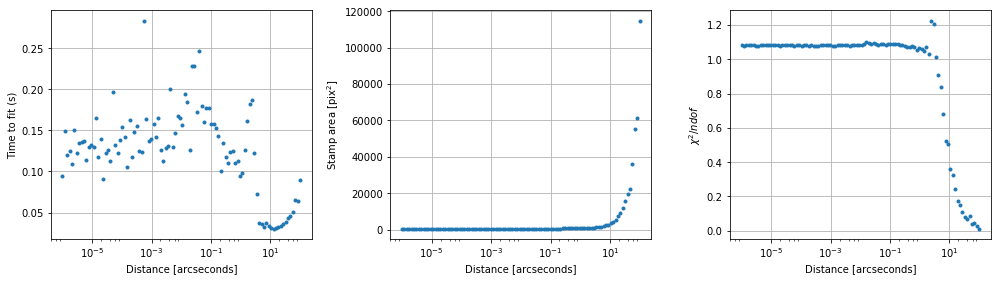

In [99]:
summary_plots(distance, np.mean(t_arr,axis=1), np.mean(s_arr,axis=1), np.mean(rchi_arr,axis=1),'Distance [arcseconds]',xlogscale=True)

In [118]:
npoints=100
nreps=5
t_arr = np.zeros((npoints,nreps))
s_arr = np.zeros((npoints,nreps))
rchi_arr = np.zeros((npoints,nreps))
distance = np.logspace(-6,2,npoints)
for j in range(nreps):
    for i in range(npoints):
        t_arr[i,j], s_arr[i,j], rchi_arr[i,j] = time_two_galaxies(distance[i],0,0,1,0,0,0.5,1,1,1, add_noise=True, fixed_position=True)

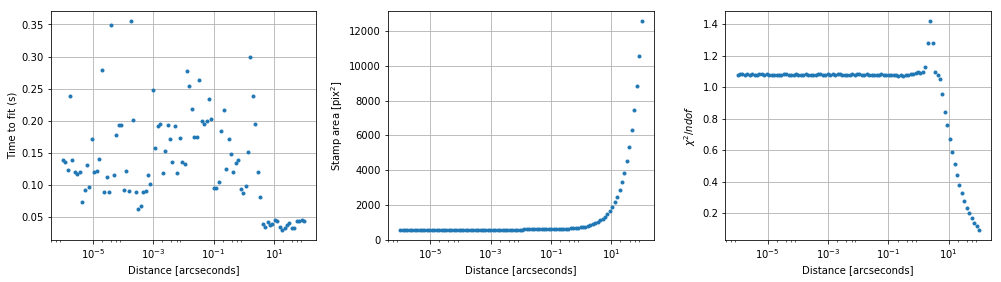

In [119]:
summary_plots(distance, np.mean(t_arr,axis=1), np.mean(s_arr,axis=1), np.mean(rchi_arr,axis=1),'Distance [arcseconds]',xlogscale=True)

# Dependence on the flux ratio (distance = 10", mag$_{0}$ = 19, $\sigma_{-}$= 0.5", circular) 

In [100]:
npoints=100
nreps=5
t_arr = np.zeros((npoints,nreps))
s_arr = np.zeros((npoints,nreps))
rchi_arr = np.zeros((npoints,nreps))
flux_ratio = np.logspace(-4,0,npoints)
for j in range(nreps):
    for i in range(npoints):
        t_arr[i,j], s_arr[i,j], rchi_arr[i,j] = time_two_galaxies(10,0,0,flux_ratio[i],0,0,0.5,1,1,1,mag0=19.5, add_noise=True)

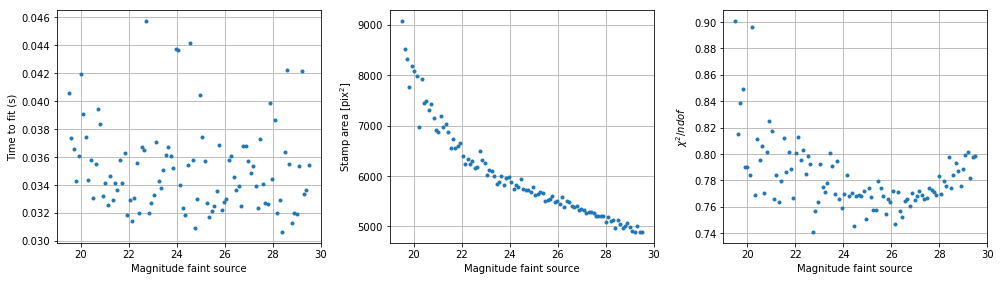

In [101]:
magnitude = 19.5-2.5*np.log10(flux_ratio)
summary_plots(magnitude,np.mean(t_arr,axis=1),np.mean(s_arr,axis=1),np.mean(rchi_arr,axis=1),'Magnitude faint source')

In [120]:
npoints=100
nreps=5
t_arr = np.zeros((npoints,nreps))
s_arr = np.zeros((npoints,nreps))
rchi_arr = np.zeros((npoints,nreps))
flux_ratio = np.logspace(-4,0,npoints)
for j in range(nreps):
    for i in range(npoints):
        t_arr[i,j], s_arr[i,j], rchi_arr[i,j] = time_two_galaxies(10,0,0,flux_ratio[i],0,0,0.5,1,1,1,mag0=19.5, add_noise=True, fixed_position=True)

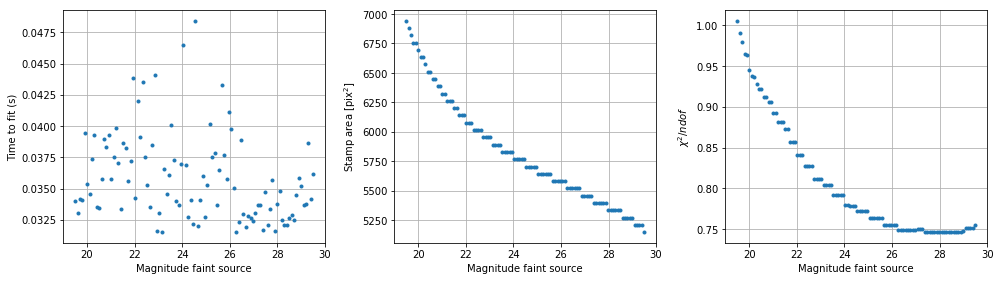

In [121]:
magnitude = 19.5-2.5*np.log10(flux_ratio)
summary_plots(magnitude,np.mean(t_arr,axis=1),np.mean(s_arr,axis=1),np.mean(rchi_arr,axis=1),'Magnitude faint source')

# Dependence on the size ratio (distance = 10", mag = 24, $\sigma_{-}$= 2.0", circular) 

In [102]:
npoints=100
nreps=5
t_arr = np.zeros((npoints,nreps))
s_arr = np.zeros((npoints,nreps))
rchi_arr = np.zeros((npoints,nreps))
size_ratio = np.linspace(0.1,1,npoints)
for j in range(nreps):
    for i in range(npoints):
        t_arr[i], s_arr[i], rchi_arr[i] = time_two_galaxies(10,0,0,1,0,0,2.,size_ratio[i],1,1,add_noise=True)

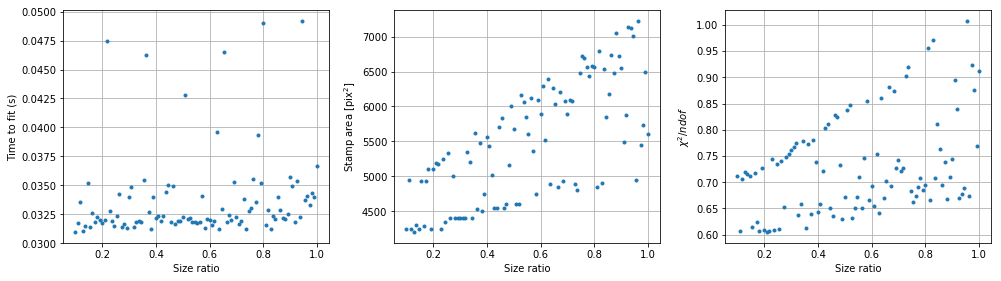

In [103]:
summary_plots(size_ratio,np.mean(t_arr,axis=1),np.mean(s_arr,axis=1),np.mean(rchi_arr,axis=1),'Size ratio')

In [122]:
npoints=100
nreps=5
t_arr = np.zeros((npoints,nreps))
s_arr = np.zeros((npoints,nreps))
rchi_arr = np.zeros((npoints,nreps))
size_ratio = np.linspace(0.1,1,npoints)
for j in range(nreps):
    for i in range(npoints):
        t_arr[i], s_arr[i], rchi_arr[i] = time_two_galaxies(10,0,0,1,0,0,2.,size_ratio[i],1,1,add_noise=True, fixed_position=True)

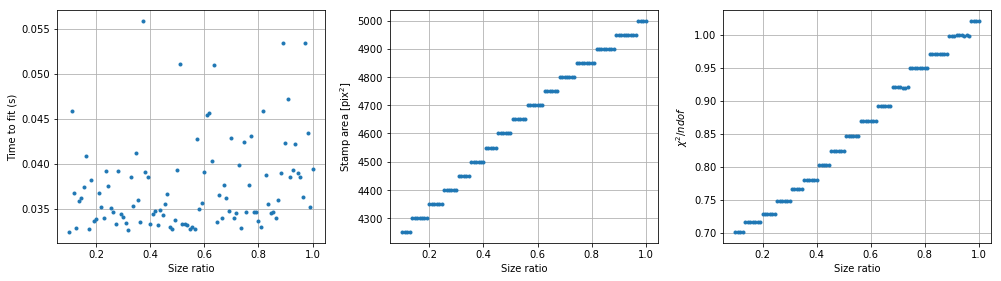

In [123]:
summary_plots(size_ratio,np.mean(t_arr,axis=1),np.mean(s_arr,axis=1),np.mean(rchi_arr,axis=1),'Size ratio')

# Dependence on $q$ ratio (distance=10", mag=24, $\sigma_{-}=0.5"$, $q_{0}=1$)

In [107]:
npoints=100
nreps=10
t_arr = np.zeros((npoints,nreps))
s_arr = np.zeros((npoints,nreps))
rchi_arr = np.zeros((npoints,nreps))
q_ratio = np.linspace(0.1,1,npoints)
for j in range(nreps):
    for i in range(npoints):
        t_arr[i], s_arr[i], rchi_arr[i] = time_two_galaxies(10,0,0,1,0,0,0.5,1,1,q_ratio[i],add_noise=True)

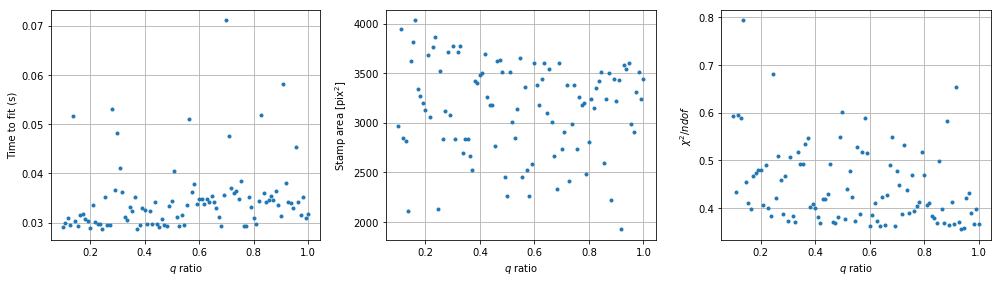

In [108]:
summary_plots(q_ratio,np.mean(t_arr,axis=1),np.mean(s_arr,axis=1),np.mean(rchi_arr,axis=1),'$q$ ratio')

In [124]:
npoints=100
nreps=10
t_arr = np.zeros((npoints,nreps))
s_arr = np.zeros((npoints,nreps))
rchi_arr = np.zeros((npoints,nreps))
q_ratio = np.linspace(0.1,1,npoints)
for j in range(nreps):
    for i in range(npoints):
        t_arr[i], s_arr[i], rchi_arr[i] = time_two_galaxies(10,0,0,1,0,0,0.5,1,1,q_ratio[i],add_noise=True,fixed_position=True)

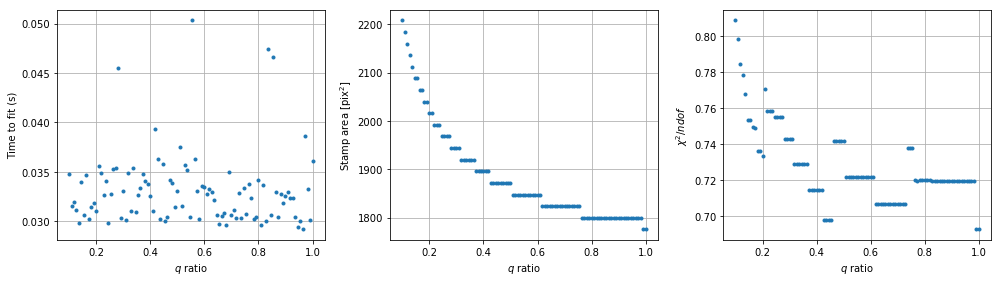

In [125]:
summary_plots(q_ratio,np.mean(t_arr,axis=1),np.mean(s_arr,axis=1),np.mean(rchi_arr,axis=1),'$q$ ratio')

# Dependence on orientation (distance=10", mag=24, $\sigma_{-}=0.5"$, $\beta_{0}=0$, $q=0.5$)

In [110]:
npoints=100
nreps=10
t_arr = np.zeros((npoints,nreps))
s_arr = np.zeros((npoints,nreps))
rchi_arr = np.zeros((npoints,nreps))
beta = np.linspace(-np.pi,np.pi,npoints)
for j in range(nreps):
    for i in range(npoints):
        t_arr[i], s_arr[i], rchi_arr[i] = time_two_galaxies(10,0,0,1,0,beta[i],0.5,1,0.5,1,add_noise=True)

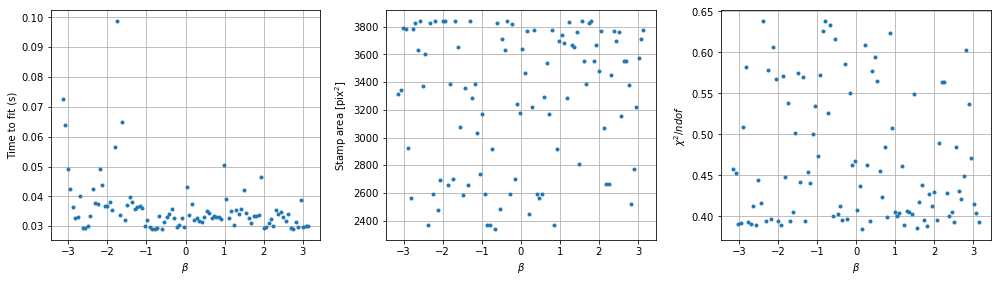

In [113]:
summary_plots(beta,np.mean(t_arr,axis=1),np.mean(s_arr,axis=1),np.mean(rchi_arr,axis=1),r'$\beta$')

In [115]:
npoints=100
nreps=10
t_arr = np.zeros((npoints,nreps))
s_arr = np.zeros((npoints,nreps))
rchi_arr = np.zeros((npoints,nreps))
beta = np.linspace(-np.pi,np.pi,npoints)
for j in range(nreps):
    for i in range(npoints):
        t_arr[i], s_arr[i], rchi_arr[i] = time_two_galaxies(10,0,0,1,0,beta[i],0.5,1,0.5,1,add_noise=True,fixed_position=True)

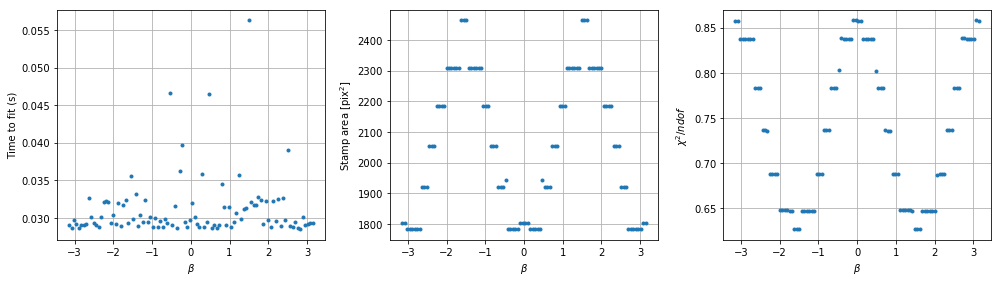

In [116]:
summary_plots(beta,np.mean(t_arr,axis=1),np.mean(s_arr,axis=1),np.mean(rchi_arr,axis=1),r'$\beta$')

From these plots it looks like that the overlap between the two sources is the dominant effect increasing the fitting time.